# Regressions Diagnostics and Residual Plots

- linear regression assumptions, residual plots, robust standard errors
- outliers, leverage, multicollinearity
- statsmodels, St Louis Fed FRED

Author: Terence Lim

In [1]:
import numpy as np
import pandas as pd
from pandas import DataFrame, Series
import matplotlib.pyplot as plt
import time
import os
import seaborn as sns 
from finds.alfred import Alfred

from settings import settings
imgdir = os.path.join(settings['images'], 'ts')
alf = Alfred(api_key=settings['fred']['api_key'])


## Linear Regression on lagged GDP

In [2]:
s = 'GDPC1'
df = alf(s, log=1, freq='Q')
df.index = pd.DatetimeIndex(df.index.astype(str))
data = df.to_frame().diff().dropna()

import statsmodels.formula.api as smf
model = smf.ols(formula='GDPC1 ~ GDPC1.shift(1)', data=data).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  GDPC1   R-squared:                       0.014
Model:                            OLS   Adj. R-squared:                  0.010
Method:                 Least Squares   F-statistic:                     4.091
Date:                Tue, 09 Mar 2021   Prob (F-statistic):             0.0440
Time:                        16:08:32   Log-Likelihood:                 894.08
No. Observations:                 294   AIC:                            -1784.
Df Residuals:                     292   BIC:                            -1777.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          0.0067      0.001      8.303      0.000       0.005       0.008
GDPC1.shift(1)     0.1174      0.058      2.023      0.044       0.003       0.232
==============================================================================
Omnibus:                      143.337   Durbin-Watson:                   2.025
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             6980.745
Skew:                          -1.180   Prob(JB):                         0.00
Kurtosis:                      26.755   Cond. No.                         85.8
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Plot residuals and identify outliers

date,1950-03-31,2020-09-30,2020-06-30
outliers,0.03285,0.076489,-0.099354


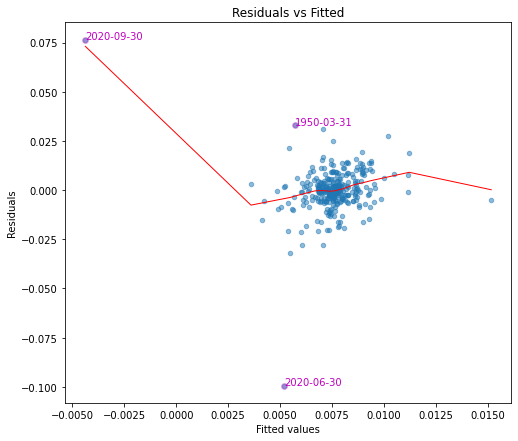

In [3]:
# Convenience method to plot residuals and identify outliers
def plot_fitted(fitted, resid, n=3, ax=None, title='', fontsize=12,
                strftime='%Y-%m-%d'):
    ax = ax or plt.gca()
    outliers = np.argpartition(resid.abs().values, -n)[-n:]
    sns.regplot(x=fitted, y=resid, lowess=True, ax=ax,
                scatter_kws={"s": 20, 'alpha': 0.5},
                line_kws={"color": "r", "lw": 1})
    ax.scatter(fitted[outliers], resid[outliers], c='m', alpha=.25)
    for i in outliers:
        ax.annotate(resid.index[i].strftime(strftime) if strftime else
                    str(resid.index[i]), xy=(fitted.iloc[i],resid.iloc[i]),
                    c='m')
    ax.set_title(title or f"Residuals vs Fitted")
    ax.set_xlabel("Fitted values")
    ax.set_ylabel("Residuals")
    return resid.iloc[outliers].rename('outliers')

# Plot residuals and identify outliers
fig, ax = plt.subplots(num=1, clear=True, figsize=(8,7))
z = plot_fitted(fitted=model.fittedvalues, resid=model.resid, ax=ax)
plt.savefig(os.path.join(imgdir, 'outliers.jpg'))
z.to_frame().T

## QQ Plot of residuals and identify outliers and non-normality

,residuals,standardized
date,,
2020-06-30,-0.099354,-8.593085
1950-03-31,0.032850,2.841171
2020-09-30,0.076489,6.615453


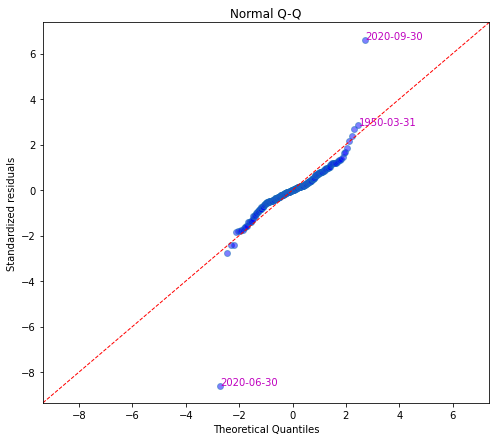

In [4]:
## Convenience wrapper over QQ Plot
from statsmodels.graphics.gofplots import ProbPlot
import statsmodels.api as sm 
def plot_qq(resid, title='', ax=None, z=2.807, strftime='%Y-%m-%d'):
    pp = ProbPlot(resid, fit=True)
    outliers = abs(pp.sample_quantiles) > z
    ax = ax or plt.gca()
    pp.qqplot(ax=ax, color='C0', alpha=.5)
    sm.qqline(ax=ax, line='45', fmt='r--', lw=1)
    z = resid.sort_values().index[outliers]
    for x, y, i in zip(pp.theoretical_quantiles[outliers],
                       pp.sample_quantiles[outliers], z):
        ax.annotate(i.strftime(strftime) if strftime else str(i),
                    xy=(x,y),c='m')
    ax.set_title(title or 'Normal Q-Q')
    ax.set_ylabel('Standardized residuals')
    return DataFrame({'residuals': pp.sorted_data[outliers], 'standardized':
                      pp.sample_quantiles[outliers]}, index=z)
    
## QQ Plot of residuals and identify outliers
fig, ax = plt.subplots(num=4, clear=True, figsize=(8,7))
z = plot_qq(model.resid, ax=ax)
plt.savefig(os.path.join(imgdir, 'qq.jpg'))
z

## Plot scale and location of residuals, with outliers, to check constant variance assumption

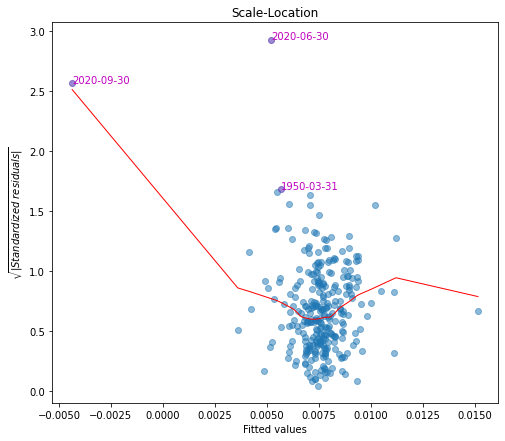

In [5]:
## Convenience method to plot scale of residuals with outliers    
def plot_scale(fitted, resid, ax=None, title='', n=3, strftime='%Y-%m-%d'):
    ax = ax or plt.gca()
    resid = np.sqrt(np.abs(resid/resid.std()))
    ax.scatter(fitted, resid, alpha=0.5);
    sns.regplot(fitted, resid, scatter=False, ci=False, lowess=True,
                line_kws={'color': 'r', 'lw': 1});
    ax.set_title(title or f"Scale-Location")
    ax.set_ylabel('$\sqrt{|Standardized \ residuals|}$');
    ax.set_xlabel('Fitted values')
    outliers = np.argpartition(resid.values, -n)[-n:]
    ax.scatter(fitted[outliers], resid[outliers], c='m', alpha=.25)
    for i in outliers:
        ax.annotate(resid.index[i].strftime(strftime) if strftime else
                    str(resid.index[i]), xy=(fitted[i], resid[i]), c='m')

## Plot scale of residuals with outliers
fig, ax = plt.subplots(num=3, clear=True, figsize=(8,7))
plot_scale(model.fittedvalues, model.resid, ax=ax)
plt.savefig(os.path.join(imgdir, 'scale.jpg'))

## Heteroskedasity and autocorrelation consistent (HAC) robust error estimates

In [6]:
    robust = model.get_robustcov_results(cov_type='HAC', use_t=None, maxlags=0)
    robust.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  GDPC1   R-squared:                       0.014
Model:                            OLS   Adj. R-squared:                  0.010
Method:                 Least Squares   F-statistic:                    0.3241
Date:                Tue, 09 Mar 2021   Prob (F-statistic):              0.570
Time:                        16:08:46   Log-Likelihood:                 894.08
No. Observations:                 294   AIC:                            -1784.
Df Residuals:                     292   BIC:                            -1777.
Df Model:                           1                                         
Covariance Type:                  HAC                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          0.0067      0.002      3.380      0.001       0.003       0.011
GDPC1.shift(1)     0.1174      0.206      0.569      0.570      -0.288       0.523
==============================================================================
Omnibus:                      143.337   Durbin-Watson:                   2.025
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             6980.745
Skew:                          -1.180   Prob(JB):                         0.00
Kurtosis:                      26.755   Cond. No.                         85.8
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 0 lags and without small sample correction
"""

## Plot leverage and identify influential points

,outlier,cook's D,leverage
date,,,
2020-09-30,0.076489,10.469686,0.262219


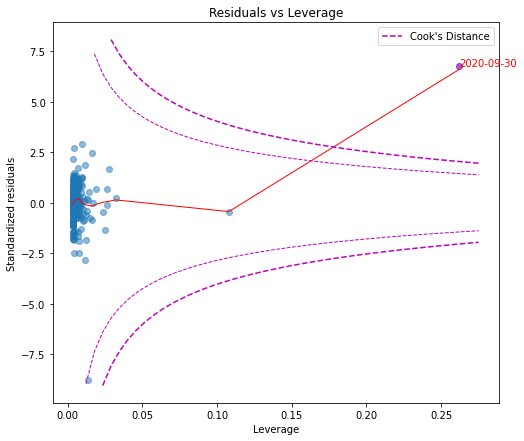

In [8]:
## Convenience method to plot leverage and identify influential points
def plot_leverage(resid, h, d, ddof, ax=None, strftime='%Y-%m-%d'):
    ax = ax or plt.gca()
    s = np.sqrt(np.sum(np.array(resid)**2 * (1 - h))/(len(h) - ddof))
    r = resid/s   # studentized residual
    sns.regplot(h, r, scatter=True, ci=False, lowess=True,
                scatter_kws={'alpha': 0.5}, line_kws={'color': 'r', 'lw': 1})
    influential = np.where(d > 1)[0]
    ax.scatter(h[influential], r[influential], c='m', alpha=.5)
    for i in influential:
        ax.annotate(r.index[i].strftime(strftime) if strftime else
                    str(r.index[i]), xy=(h[i], r[i]), c='r')
    ax.set_title("Residuals vs Leverage")
    ax.set_xlabel("Leverage")
    ax.set_ylabel("Standardized residuals")
    legend = None
    x = np.linspace(0.001, ax.get_xlim()[1], 50)    
    for sign in [1, -1]:   # plot Cook's Distance thresholds (both signs)
        for thresh in [.5, 1]:
            y = sign * np.sqrt(thresh * ddof / x) * (1-x)
            g = (y > ax.get_ylim()[0]) & (y < ax.get_ylim()[1])
            if g.any():
                legend, = ax.plot(x[g], y[g], color='m', lw=.5+thresh, ls='--')
    if legend:
        legend.set_label("Cook's Distance")
        ax.legend(loc='best')
    return DataFrame({'outlier': resid.iloc[influential],
                      "cook's D": d[influential],
                      "leverage": h[influential]},
                     index=resid.iloc[influential].index)

## Plot leverage and identify influential points                 
fig, ax = plt.subplots(num=2, clear=True, figsize=(8,7))
z = plot_leverage(model.resid, model.get_influence().hat_matrix_diag,
                  model.get_influence().cooks_distance[0],
                  ddof=len(model.params), ax=ax)
plt.savefig(os.path.join(imgdir, 'leverage.jpg'))
z

## Polynomial Regressions and Interactions

In [9]:
dmf = ('GDPC1 ~ GDPC1.shift(1) + I(GDPC1.shift(1)**2)' # quadratic polynomial
       ' + GDPC1.shift(1):GDPC1.shift(2)')             # interaction term

model = smf.ols(formula=(dmf), data=data).fit()
robust = model.get_robustcov_results(cov_type='HAC', use_t=None, maxlags=2)
robust.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  GDPC1   R-squared:                       0.209
Model:                            OLS   Adj. R-squared:                  0.201
Method:                 Least Squares   F-statistic:                     28.22
Date:                Tue, 09 Mar 2021   Prob (F-statistic):           4.94e-16
Time:                        16:10:13   Log-Likelihood:                 923.26
No. Observations:                 293   AIC:                            -1839.
Df Residuals:                     289   BIC:                            -1824.
Df Model:                           3                                         
Covariance Type:                  HAC                                         
=================================================================================================
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept                         0.0039      0.001      3.245      0.001       0.002       0.006
GDPC1.shift(1)                    0.2139      0.068      3.142      0.002       0.080       0.348
I(GDPC1.shift(1) ** 2)            8.0345      0.953      8.432      0.000       6.159       9.910
GDPC1.shift(1):GDPC1.shift(2)     7.4969      1.162      6.451      0.000       5.210       9.784
==============================================================================
Omnibus:                      222.914   Durbin-Watson:                   2.014
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             7790.536
Skew:                          -2.626   Prob(JB):                         0.00
Kurtosis:                      27.709   Cond. No.                     2.50e+03
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 2 lags and without small sample correction
[2] The condition number is large, 2.5e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## Residual Plots

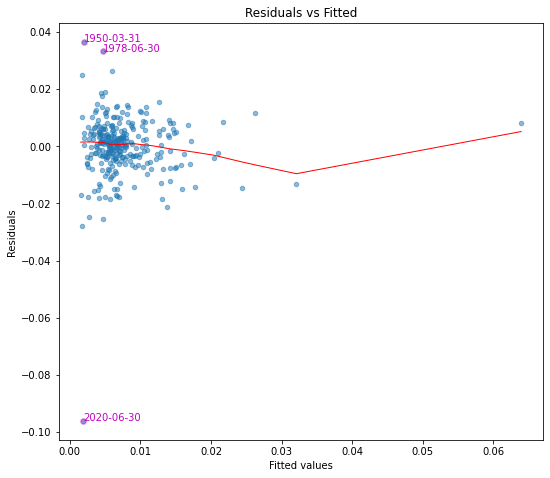

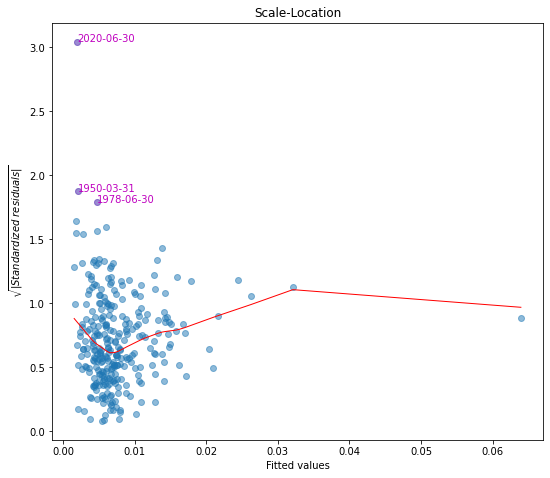

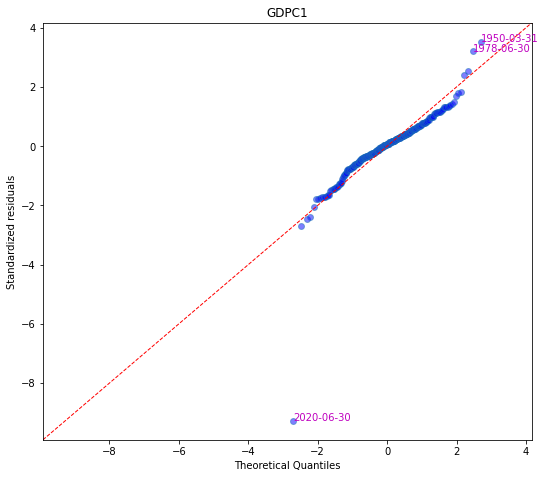

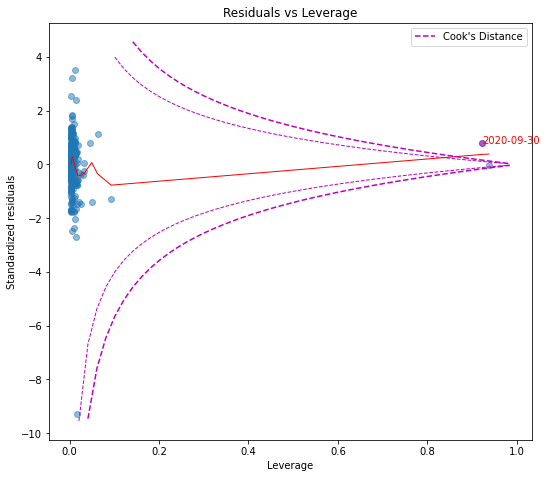

,outlier,cook's D,leverage
date,,,
2020-09-30,0.00816,22.971634,0.921641


In [10]:
fig, ax = plt.subplots(num=1, clear=True, figsize=(8,7))
z = plot_fitted(fitted=model.fittedvalues, resid=model.resid, ax=ax)
plt.tight_layout(pad=2)
plt.savefig(os.path.join(imgdir, 'fitted2.jpg'))
plt.show()

fig, ax = plt.subplots(num=2, clear=True, figsize=(8,7))
plot_scale(model.fittedvalues, model.resid, ax=ax)
plt.tight_layout(pad=2)
plt.savefig(os.path.join(imgdir, 'scale2.jpg'))
plt.show()

fig, ax = plt.subplots(num=4, clear=True, figsize=(8,7))
z = plot_qq(model.resid, ax=ax, title=s)
plt.tight_layout(pad=2)
plt.savefig(os.path.join(imgdir, 'qq2.jpg'))
plt.show()
    
fig, ax = plt.subplots(num=3, clear=True, figsize=(8,7))
z = plot_leverage(model.resid, model.get_influence().hat_matrix_diag,
                  model.get_influence().cooks_distance[0],
                  ddof=len(model.params), ax=ax)
plt.tight_layout(pad=2)
plt.savefig(os.path.join(imgdir, 'leverage2.jpg'))
plt.show()
z

## Detect Multicollinearity
- Variance Inflation Factor > 5

In [11]:
import patsy
from statsmodels.stats.outliers_influence import variance_inflation_factor
Y, X = patsy.dmatrices(dmf + ' - 1', data=data)  # exclude intercept term
DataFrame({X.design_info.column_names[i]: variance_inflation_factor(X, i)
           for i in range(X.shape[1])}, index=['VIF'])

,GDPC1.shift(1),I(GDPC1.shift(1) ** 2),GDPC1.shift(1):GDPC1.shift(2)
VIF,1.0138,1.039675,1.039905
